<a href="https://colab.research.google.com/github/atlantiquesun/Stock_ML/blob/main/stock_two_step_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot as plt

%tensorflow_version 2.x
import tensorflow as tf

#1. Preprocessing Data

1.   data from 2019-12-04 to 2021-06-30
2.   use differencing
3.   assume that we can only buy stocks at the beginning of a trading day, and sell stocks at the end of a trading day
4.   assume that we cannot buy and then sell the same stocks in the same trading day 



In [4]:

def make_multistep_dataset(df, features_column, steps=1):
  
  for i in range(steps):
    for feature in features_column:
      df[feature+"(t-"+str(i+1)+")"] = df[feature+"(t)"].shift(i+1)
  
  df = df.dropna()
  return df


def get_file_index(file_name):

    index = file_name.split(".")[0]
    start = 0
    while (start < len(index) and index[start] == "0"):
      start += 1
    return int(index[start:])


def load_data(data_folder, n_stocks, steps=1): 

  files = os.listdir(data_folder)
  files.sort(key = lambda x: get_file_index(x))
  columns = ["open(t)", "close(t)", "high(t)", "low(t)"]

  df = None
  for i in range(n_stocks):
    
    # get file name
    file = files[i]

    # load data
    df_temp = pd.read_csv(data_folder+"/"+file, names=columns)

    # get the target (before differencing)
    df_temp["y(t)"] = (df_temp["close(t)"]-df_temp["open(t)"].shift(1))/df_temp["open(t)"].shift(1)

    # differencing
    for column in columns:
      df_temp[column] = (df_temp[column] - df_temp[column].shift(1))/df_temp[column].shift(1)

    # make multistep dataset
    features_column = [x[:-3] for x in columns]
    df_temp = make_multistep_dataset(df_temp, features_column, steps)
    df_temp['time_index'] = df_temp.index #keep the original timestep index of each record
    df_temp['ticker'] = file.split('.')[0] #get the ticker number

    # concatenate with df
    if (i==0):
      df = df_temp
    else:
      df = pd.concat([df, df_temp])

    # make sure the index is correct
    df = df.reset_index(drop = True)
  
  return df


# 2. Prepare Training and Testing Sets

In [5]:
def prepare_train_data(df, features_column, steps, start=0, train_window=36, start_step=2): 
  '''
  'features_column' here do not have to be the same as 'features_column' in make_multistep_dataset() 
  'target_column' is a string, e.g. "open"
  'start_step = 2': two-step prediction
  '''

  df = df.loc[(df.time_index >= start) & (df.time_index < start+train_window)]

  # columns used for prediction
  train_columns = []
  for i in range(start_step, steps+1):
      train_columns.extend([x+"(t-"+str(i)+")" for x in features_column])
  
  # fit transform the data
  scaler = MinMaxScaler()
  transform_columns = train_columns + ["y(t)"]
  df[transform_columns] = scaler.fit_transform(df[transform_columns])

  # X, y
  X_train = df[train_columns].values
  X_train_lstm = np.reshape(X_train, (X_train.shape[0], (steps-start_step+1), len(features_column))) #lstm data shape: (samples, timesteps, features)
  y_train = df["y(t)"].values

  print(X_train.shape, X_train_lstm.shape, y_train.shape)
  return (X_train, X_train_lstm, y_train, scaler) #scaler is to be used on the test set




def prepare_test_data(df, scaler, features_column, steps, start=0, test_window=12, start_step=2):

  df = df.loc[(df.time_index >= start) & (df.time_index < start+test_window)]

  # columns used for prediction
  test_columns = []
  for i in range(start_step, steps+1):
    test_columns.extend([x+"(t-"+str(i)+")" for x in features_column])
  
  # transform the data
  transform_columns = test_columns + ["y(t)"]
  df[transform_columns] = scaler.transform(df[transform_columns])

  # X, y
  X_test = df[test_columns].values
  X_test_lstm = np.reshape(X_test, (X_test.shape[0], (steps-start_step+1), len(features_column)))
  y_test = df["y(t)"].values

  return (X_test, X_test_lstm, y_test)



def prepare_trade_data(df, scaler, features_column, steps, trade_start, start_step=2):

  df = df.loc[df.time_index.isin([trade_start])]

  # columns used for prediction
  trade_columns = []
  for i in range(start_step, steps+1):
    trade_columns.extend([x+"(t-"+str(i)+")" for x in features_column])
  
  # transform the data
  transform_columns = trade_columns + ["y(t)"]
  df[transform_columns] = scaler.transform(df[transform_columns])

  # X, y
  X_trade = df[trade_columns].values
  X_trade_lstm = np.reshape(X_trade, (X_trade.shape[0], (steps-start_step+1), len(features_column)))
  y_trade = df["y(t)"].values

  return (X_trade, X_trade_lstm, y_trade)
    


# 3. Models

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import SGD

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor



def train_lstm(X_train, y_train, epochs=50, batch_size=64):

  with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(LSTM(12, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.5))
    model.add(Dense(12, activation="tanh"))
    model.add(Dense(1))

    model.compile(loss='mae', optimizer="adam")
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2, shuffle=False)
    return model


def train_lr(X_train, y_train):
  
  lr_regressor = LinearRegression()
  model = lr_regressor.fit(X_train, y_train)

  return model


def train_lasso(X_train, y_train):

  lasso_regressor = Lasso(alpha=0.001)
  model = lasso_regressor.fit(X_train, y_train)
  return model


def train_ridge(X_train, y_train):

  ridge_regressor = Ridge(alpha=0.0001)
  model = ridge_regressor.fit(X_train, y_train)

  return model


def train_svm(X_train, y_train):
  with tf.device('/device:GPU:0'):
    svr = SVR(C=1.0, kernel='rbf', gamma=0.1)
    model = svr.fit(X_train, y_train)
    return model


def train_gbm(X_train, y_train):
  with tf.device('/device:GPU:0'):
    gbr = GradientBoostingRegressor(loss='lad', learning_rate=0.1, n_estimators=50, max_depth=5)
    model = gbr.fit(X_train, y_train)
    return model


def train_ada(X_train, y_train):
  with tf.device('/device:GPU:0'):
    base_estimator = DecisionTreeRegressor(max_depth=5)
    ada = AdaBoostRegressor(base_estimator=base_estimator, n_estimators=50, learning_rate=0.01, loss='linear')
    model = ada.fit(X_train, y_train)
    return model


#model evaluation
def evaluate_model(model, X_test, y_test):
    from sklearn.metrics import mean_squared_error
    #from sklearn.metrics import mean_squared_log_error

    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import explained_variance_score
    from sklearn.metrics import r2_score
    y_predict = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_predict)
    

    mse = mean_squared_error(y_test, y_predict)
    #msle = mean_squared_log_error(y_test, y_predict)

    explained_variance = explained_variance_score(y_test, y_predict)
    r2 = r2_score(y_test, y_predict)

    return mae

# 4. Training

In [13]:
# prepare data
steps = 12 # include 12 timestamps for each sample
data_folder = "/content/drive/MyDrive/StockML /stock_data/processed_data"
n_stocks = 500 # use 500 stocks
df = load_data(data_folder, n_stocks, steps)
display(df)

,open(t),close(t),high(t),low(t),y(t),open(t-1),close(t-1),high(t-1),low(t-1),open(t-2),close(t-2),high(t-2),low(t-2),open(t-3),close(t-3),high(t-3),low(t-3),open(t-4),close(t-4),high(t-4),low(t-4),open(t-5),close(t-5),high(t-5),low(t-5),open(t-6),close(t-6),high(t-6),low(t-6),open(t-7),close(t-7),high(t-7),low(t-7),open(t-8),close(t-8),high(t-8),low(t-8),open(t-9),close(t-9),high(t-9),low(t-9),open(t-10),close(t-10),high(t-10),low(t-10),open(t-11),close(t-11),high(t-11),low(t-11),open(t-12),close(t-12),high(t-12),low(t-12),time_index,ticker
0,0.008055,-0.021014,0.000000,-0.016833,-0.018587,0.000000,0.002478,-0.003674,0.000000,0.006862,0.004981,0.004923,0.001874,0.026906,-0.001865,0.001850,0.026940,-0.006997,0.022886,0.030496,0.007106,0.016818,0.000636,0.001272,0.006502,0.012443,0.032852,0.028796,0.015182,0.018000,-0.003274,-0.000654,0.015416,0.001335,0.021405,0.019333,0.003362,-0.017060,-0.005323,-0.015748,-0.006680,0.009940,-0.012484,-0.005871,-0.007294,0.008016,0.011296,0.015232,0.010724,0.000668,0.008038,0.004657,0.005391,13,000001
1,-0.027044,0.010101,-0.011063,0.003805,-0.016595,0.008055,-0.021014,0.000000,-0.016833,0.000000,0.002478,-0.003674,0.000000,0.006862,0.004981,0.004923,0.001874,0.026906,-0.001865,0.001850,0.026940,-0.006997,0.022886,0.030496,0.007106,0.016818,0.000636,0.001272,0.006502,0.012443,0.032852,0.028796,0.015182,0.018000,-0.003274,-0.000654,0.015416,0.001335,0.021405,0.019333,0.003362,-0.017060,-0.005323,-0.015748,-0.006680,0.009940,-0.012484,-0.005871,-0.007294,0.008016,0.011296,0.015232,0.010724,14,000001
2,0.013898,-0.006250,0.003729,0.000632,0.004422,-0.027044,0.010101,-0.011063,0.003805,0.008055,-0.021014,0.000000,-0.016833,0.000000,0.002478,-0.003674,0.000000,0.006862,0.004981,0.004923,0.001874,0.026906,-0.001865,0.001850,0.026940,-0.006997,0.022886,0.030496,0.007106,0.016818,0.000636,0.001272,0.006502,0.012443,0.032852,0.028796,0.015182,0.018000,-0.003274,-0.000654,0.015416,0.001335,0.021405,0.019333,0.003362,-0.017060,-0.005323,-0.015748,-0.006680,0.009940,-0.012484,-0.005871,-0.007294,15,000001
3,-0.006854,0.010063,-0.004954,0.005051,0.000623,0.013898,-0.006250,0.003729,0.000632,-0.027044,0.010101,-0.011063,0.003805,0.008055,-0.021014,0.000000,-0.016833,0.000000,0.002478,-0.003674,0.000000,0.006862,0.004981,0.004923,0.001874,0.026906,-0.001865,0.001850,0.026940,-0.006997,0.022886,0.030496,0.007106,0.016818,0.000636,0.001272,0.006502,0.012443,0.032852,0.028796,0.015182,0.018000,-0.003274,-0.000654,0.015416,0.001335,0.021405,0.019333,0.003362,-0.017060,-0.005323,-0.015748,-0.006680,16,000001
4,0.011292,0.009963,0.027380,0.006910,0.017566,-0.006854,0.010063,-0.004954,0.005051,0.013898,-0.006250,0.003729,0.000632,-0.027044,0.010101,-0.011063,0.003805,0.008055,-0.021014,0.000000,-0.016833,0.000000,0.002478,-0.003674,0.000000,0.006862,0.004981,0.004923,0.001874,0.026906,-0.001865,0.001850,0.026940,-0.006997,0.022886,0.030496,0.007106,0.016818,0.000636,0.001272,0.006502,0.012443,0.032852,0.028796,0.015182,0.018000,-0.003274,-0.000654,0.015416,0.001335,0.021405,0.019333,0.003362,17,000001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183995,0.070821,-0.043656,-0.019469,-0.001607,0.024720,-0.001587,0.071497,0.072519,0.003629,-0.015201,-0.001072,-0.010237,0.000000,0.016282,-0.032383,-0.011003,0.000969,0.090417,0.033795,0.039434,0.088616,-0.025283,0.100039,0.034935,0.002025,0.087887,-0.037991,0.014130,0.047015,-0.040279,0.086480,0.052650,0.003423,0.040297,-0.039935,-0.005064,-0.008802,0.016876,0.051390,0.036186,0.021926,-0.009695,0.002263,0.007244,0.017252,-0.001475,0.004408,-0.041193,-0.019165,0.070044,0.031590,0.071974,0.078711,376,002371
183996,-0.050141,0.023542,-0.015588,0.009657,-0.020524,0.070821,-0.043656,-0.019469,-0.001607,-0.001587,0.071497,0.072519,0.003629,-0.015201,-0.001072,-0.010237,0.000000,0.016282,-0.032383,-0.

In [ ]:
# training set up 
features_column = ["open", "close", "high", "low"] 
target_column = "close"
steps = 12 # use 12 timesteps for each training sample
n_windows = 100 # 100 (train, test, trade) triples in total
train_start = steps+1 # "+1" because differencing causes one additional row to be dropped
train_starts = list(range(train_start, train_start+n_windows))
train_window = 36 # 36 days training
test_starts = list(range(train_start+train_window, train_start+train_window+n_windows))
test_window = 6
trade_starts = list(range(train_start+train_window+test_window, train_start+train_window+test_window+n_windows))
lstm_epochs = 16
unique_ticker = list(set(list(df['ticker'])))
unique_ticker.sort(key = lambda x: get_file_index(x))
unique_datetime = trade_starts


df_predict_lr = pd.DataFrame(columns=unique_ticker, index=unique_datetime)
df_predict_lasso = pd.DataFrame(columns=unique_ticker, index=unique_datetime)
df_predict_ridge = pd.DataFrame(columns=unique_ticker, index=unique_datetime)
df_predict_svm= pd.DataFrame(columns=unique_ticker, index=unique_datetime)
df_predict_gbm = pd.DataFrame(columns=unique_ticker, index=unique_datetime)
df_predict_ada = pd.DataFrame(columns=unique_ticker, index=unique_datetime)
df_predict_lstm = pd.DataFrame(columns=unique_ticker, index=unique_datetime)

df_predict_best = pd.DataFrame(columns=unique_ticker, index=unique_datetime)
df_best_model_name = pd.DataFrame(columns=['model_name'], index=unique_datetime)
df_actual = pd.DataFrame(columns=unique_ticker, index=unique_datetime)
evaluation_record = []
scalers = {}

for i in range(n_windows):

  # get start dates
  train_start = train_starts[i]
  test_start = test_starts[i]
  trade_start = trade_starts[i]

  # prepare datasets
  X_train, X_train_lstm, y_train, scaler = prepare_train_data(df, features_column, steps, train_start, train_window)
  X_test, X_test_lstm, y_test = prepare_test_data(df, scaler, features_column, steps, test_start, test_window)
  X_trade, X_trade_lstm, y_trade = prepare_trade_data(df, scaler, features_column, steps, trade_start)
  print(X_trade.shape, X_trade_lstm.shape, y_trade.shape)
  scalers[trade_start] = scaler

  # train 
  lr_model = train_lr(X_train, y_train)
  lasso_model = train_lasso(X_train, y_train)
  ridge_model = train_ridge(X_train, y_train)
  svm_model = train_svm(X_train, y_train)
  gbm_model = train_gbm(X_train, y_train)
  ada_model = train_ada(X_train, y_train)
  lstm_model = train_lstm(X_train_lstm, y_train, lstm_epochs)

  # validate
  lr_eval = evaluate_model(lr_model, X_test, y_test)
  lasso_eval = evaluate_model(lasso_model, X_test, y_test)
  ridge_eval = evaluate_model(ridge_model, X_test, y_test)
  svm_eval = evaluate_model(svm_model, X_test, y_test)
  gbm_eval = evaluate_model(gbm_model, X_test, y_test)
  ada_eval = evaluate_model(ada_model, X_test, y_test)
  lstm_eval = evaluate_model(lstm_model, X_test_lstm, y_test)

  # trade
  y_trade_lr = lr_model.predict(X_trade)
  y_trade_lasso = lasso_model.predict(X_trade)
  y_trade_ridge = ridge_model.predict(X_trade)
  y_trade_svm = svm_model.predict(X_trade)
  y_trade_gbm = gbm_model.predict(X_trade)
  y_trade_ada = ada_model.predict(X_trade)
  y_trade_lstm = lstm_model.predict(X_trade_lstm).flatten()

  eval_data = [[lr_eval, y_trade_lr], 
                    [lasso_eval, y_trade_lasso],
                    [ridge_eval, y_trade_ridge],
                    [svm_eval,y_trade_svm],
                    [gbm_eval,y_trade_gbm],                     
                    [ada_eval,y_trade_ada],
                    [lstm_eval,y_trade_lstm]
                    ]

  eval_table = pd.DataFrame(eval_data, columns=['model_eval', 'model_predict_close'],
                                  index=['lr', 'lasso','ridge', 'svm', 'gbm', 'ada', 'lstm'])   
  evaluation_record.append((trade_start, eval_table))

  # lowest error score model
  y_trade_best = eval_table.model_predict_close.values[eval_table.model_eval == eval_table.model_eval.min()][0]
  best_model_name = eval_table.index.values[eval_table.model_eval == eval_table.model_eval.min()][0]
  df_best_model_name.loc[trade_start] = best_model_name

  # prepare predicted close price table
  # assert list(trade_tic)==unique_ticker # ensure that the row is filled in correctly
  df_predict_lr.loc[trade_start] = y_trade_lr
  df_predict_lasso.loc[trade_start] = y_trade_lasso
  df_predict_ridge.loc[trade_start] = y_trade_ridge
  df_predict_svm.loc[trade_start] = y_trade_svm
  df_predict_gbm.loc[trade_start] = y_trade_gbm
  df_predict_ada.loc[trade_start] = y_trade_ada
  df_predict_lstm.loc[trade_start] = y_trade_lstm
  df_predict_best.loc[trade_start] = y_trade_best

  # fill in the actual close price
  df_actual.loc[trade_start] = y_trade

  print("Trade date:", trade_start)

# save the raw results
# df_predict_lr.to_csv("/content/drive/MyDrive/StockML /lr.csv")
# df_predict_lasso.to_csv("/content/drive/MyDrive/StockML /lasso.csv")
# df_predict_ridge.to_csv("/content/drive/MyDrive/StockML /ridge.csv")
# df_predict_svm.to_csv("/content/drive/MyDrive/StockML /svm.csv")
# df_predict_gbm.to_csv("/content/drive/MyDrive/StockML /gbm.csv")
# df_predict_ada.to_csv("/content/drive/MyDrive/StockML /ada.csv")
# df_predict_lstm.to_csv("/content/drive/MyDrive/StockML /lstm.csv")
# df_predict_best.to_csv("/content/drive/MyDrive/StockML /best.csv")
# df_actual.to_csv("/content/drive/MyDrive/StockML /actual.csv")
# df_best_model_name.to_csv("/content/drive/MyDrive/StockML /best_model_name.csv")

# 5. Visualise Prediction Results

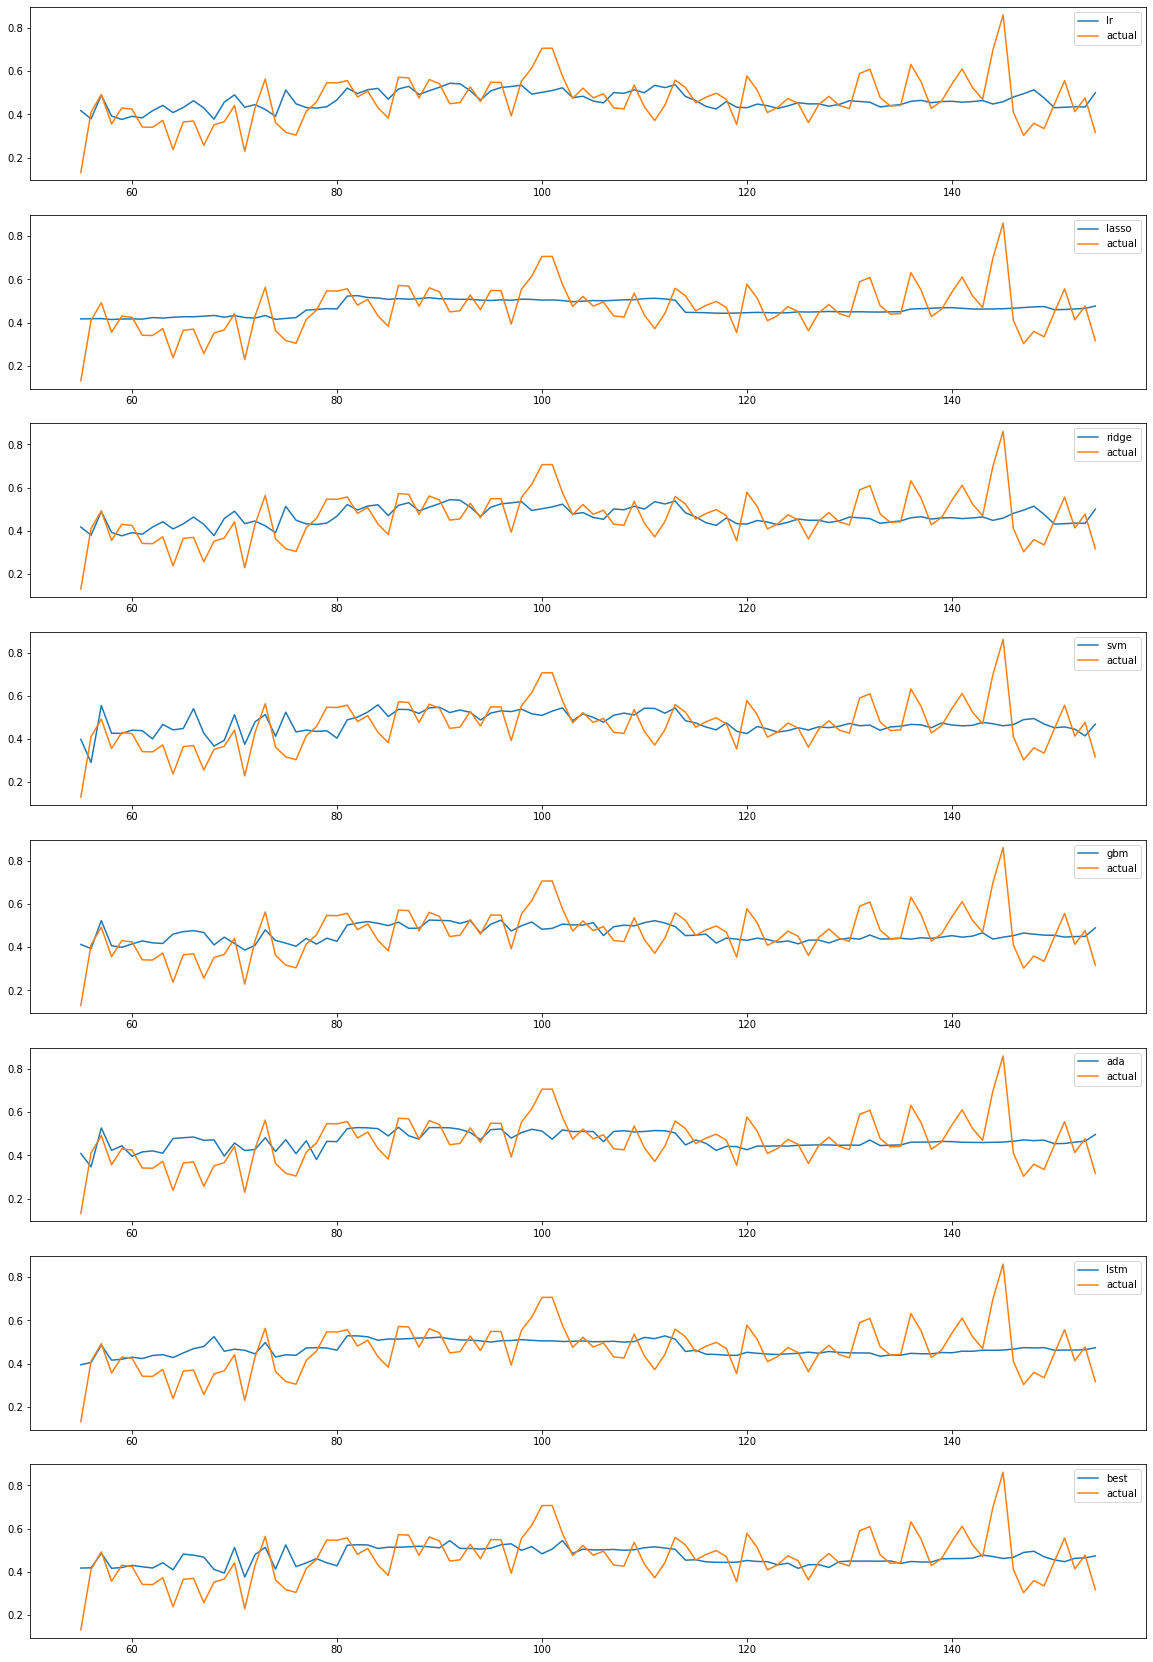

In [46]:
# retrieve results
df_predict_lr = pd.read_csv("/content/drive/MyDrive/StockML /lr.csv", index_col=0)
df_predict_lasso = pd.read_csv("/content/drive/MyDrive/StockML /lasso.csv", index_col=0)
df_predict_ridge = pd.read_csv("/content/drive/MyDrive/StockML /ridge.csv", index_col=0)
df_predict_svm = pd.read_csv("/content/drive/MyDrive/StockML /svm.csv", index_col=0)
df_predict_gbm = pd.read_csv("/content/drive/MyDrive/StockML /gbm.csv", index_col=0)
df_predict_ada = pd.read_csv("/content/drive/MyDrive/StockML /ada.csv", index_col=0)
df_predict_lstm = pd.read_csv("/content/drive/MyDrive/StockML /lstm.csv", index_col=0)
df_predict_best = pd.read_csv("/content/drive/MyDrive/StockML /best.csv", index_col=0)
df_actual = pd.read_csv("/content/drive/MyDrive/StockML /actual.csv", index_col=0)
df_best_model_name = pd.read_csv("/content/drive/MyDrive/StockML /best_model_name.csv", index_col=0)

# plot
fig, axs = plt.subplots(8, figsize=(20,30))
ticker_index = 4 # the index of the ticker (start from 0)
x = trade_starts
axs[0].plot(x, df_predict_lr[unique_ticker[ticker_index]], label="lr")
axs[0].plot(x, df_actual[unique_ticker[ticker_index]], label="actual")
axs[1].plot(x, df_predict_lasso[unique_ticker[ticker_index]], label="lasso")
axs[1].plot(x, df_actual[unique_ticker[ticker_index]], label="actual")
axs[2].plot(x, df_predict_ridge[unique_ticker[ticker_index]], label="ridge")
axs[2].plot(x, df_actual[unique_ticker[ticker_index]], label="actual")
axs[3].plot(x, df_predict_svm[unique_ticker[ticker_index]], label="svm")
axs[3].plot(x, df_actual[unique_ticker[ticker_index]], label="actual")
axs[4].plot(x, df_predict_gbm[unique_ticker[ticker_index]], label="gbm")
axs[4].plot(x, df_actual[unique_ticker[ticker_index]], label="actual")
axs[5].plot(x, df_predict_ada[unique_ticker[ticker_index]], label="ada")
axs[5].plot(x, df_actual[unique_ticker[ticker_index]], label="actual")
axs[6].plot(x, df_predict_lstm[unique_ticker[ticker_index]], label="lstm")
axs[6].plot(x, df_actual[unique_ticker[ticker_index]], label="actual")
axs[7].plot(x, df_predict_best[unique_ticker[ticker_index]], label="best")
axs[7].plot(x, df_actual[unique_ticker[ticker_index]], label="actual")
for i in range(8):
  axs[i].legend()
plt.show()

# 6. Calculate Return

In [52]:
# calculate actual return
actual_return = pd.DataFrame(columns=unique_ticker, index=unique_datetime)

for trade_start in trade_starts:

  daily_return = df.loc[df.time_index.isin([trade_start])]['y(t)']
  tickers = df.loc[df.time_index.isin([trade_start])]['ticker']
  assert (list(tickers) == unique_ticker) # ensure that the broadcast is correct
  actual_return.at[trade_start] = daily_return.values

In [126]:

# different trading strategies

def strategy_one(df_predict_return, actual_return, trade_starts, top_quantile_threshold=0.75):
  '''
  This strategy separates trading days into two-day intervals. In each interval the trader buys the top 25% stocks
  as predicted by 'df_predict_return' when the market opens on the first day, and he sells all these stocks when the
  market closes on the second day. 
  '''
  sell_dates = []
  for i in range(0, len(trade_starts), 2):
    sell_dates.append(trade_starts[i])

  actual_return = actual_return[actual_return.index.isin(sell_dates)]
  df_predict_return = df_predict_return[df_predict_return.index.isin(sell_dates)]

  long_dict = {}
  for i in range(df_predict_return.shape[0]):
      top_q = df_predict_return.iloc[i].quantile(top_quantile_threshold)
      # Select Top 25% Stocks
      long_dict[df_predict_return.index[i]] = df_predict_return.iloc[i][df_predict_return.iloc[i] >= top_q]

  portfolio_return_dic = {}
  for i in range(len(sell_dates)): 
  
      # calculate weights based on predicted return
      min_return = min(long_dict[sell_dates[i]].values)
      long_normalize_weight = (long_dict[sell_dates[i]]-min_return) / sum(long_dict[sell_dates[i]].values - min_return)
      # map date and tic
      long_tic_return = actual_return[actual_return.index == sell_dates[i]][long_dict[sell_dates[i]].index]
      # return * weight
      long_return_table = long_tic_return * long_normalize_weight
      portfolio_return_dic[sell_dates[i]] = long_return_table.values.sum()
  
  df_portfolio_return = pd.DataFrame.from_dict(portfolio_return_dic, orient='index')
  df_portfolio_return = df_portfolio_return.reset_index()
  df_portfolio_return.columns = ['trade_start', 'return']
  df_portfolio_return.index = df_portfolio_return.trade_start
  df_portfolio_return = df_portfolio_return['return']

  return df_portfolio_return


def strategy_two(df_predict_return, actual_return, trade_starts, top_quantile_threshold=0.75):

  df_portfolio_return_0 = strategy_one(df_predict_return, actual_return, trade_starts, top_quantile_threshold=0.75)
  df_portfolio_return_1 = strategy_one(df_predict_return, actual_return, trade_starts[1:], top_quantile_threshold=0.75)

  df_portfolio_return = pd.DataFrame(index=trade_starts, columns=['return'])
  for i in range(len(trade_starts)):
    if (i%2 == 0):
      df_portfolio_return.at[trade_starts[i], 'return'] = df_portfolio_return_0[trade_starts[i]]*0.5
    else:
      df_portfolio_return.at[trade_starts[i], 'return'] = df_portfolio_return_1[trade_starts[i]]*0.5
    
  return df_portfolio_return['return']


1. Trading Strategy One

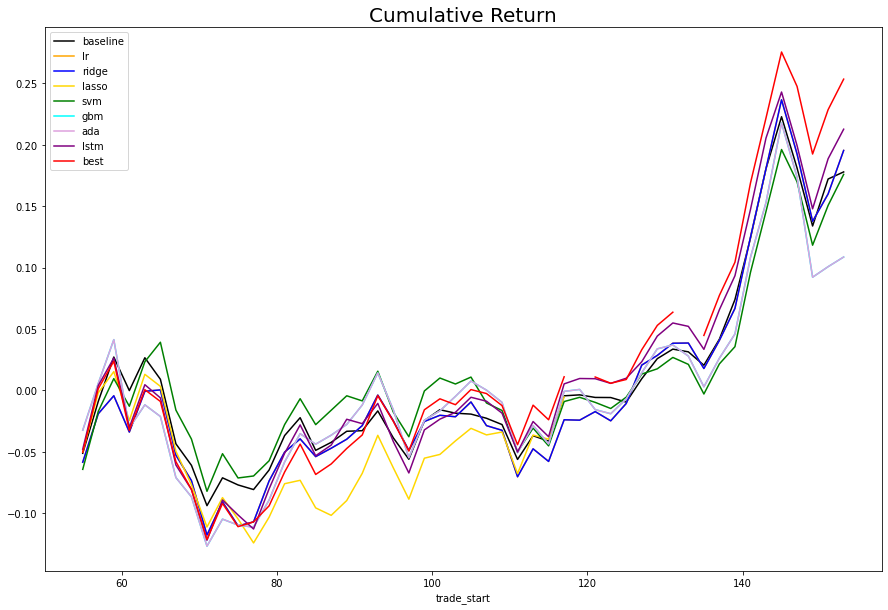

In [131]:
# trading strategy one 

# get return
df_portfolio_return_lr = strategy_one(df_predict_lr, actual_return, trade_starts,top_quantile_threshold = 0.75)
df_portfolio_return_lasso = strategy_one(df_predict_lasso, actual_return, trade_starts,top_quantile_threshold = 0.75)
df_portfolio_return_ridge = strategy_one(df_predict_ridge, actual_return, trade_starts,top_quantile_threshold = 0.75)
df_portfolio_return_svm   = strategy_one(df_predict_svm,  actual_return, trade_starts,top_quantile_threshold = 0.75)
df_portfolio_return_gbm   = strategy_one(df_predict_gbm,  actual_return, trade_starts,top_quantile_threshold = 0.75)
df_portfolio_return_ada   = strategy_one(df_predict_ada,  actual_return, trade_starts,top_quantile_threshold = 0.75)
df_portfolio_return_lstm  = strategy_one(df_predict_lstm, actual_return, trade_starts,top_quantile_threshold = 0.75)
df_portfolio_return_best  = strategy_one(df_predict_best, actual_return,trade_starts,top_quantile_threshold = 0.75)

#get equally portfolio return
equally_portfolio_return=[]
for i in range(0, len(trade_starts), 2):
    equally_portfolio_return.append(actual_return.loc[actual_return.index == trade_starts[i]].values.sum()/len(unique_ticker))
    
df_equally_portfolio_return=pd.DataFrame(equally_portfolio_return,trade_starts[::2])
df_equally_portfolio_return=df_equally_portfolio_return.reset_index()
df_equally_portfolio_return.columns= ['trade_start','return']
df_equally_portfolio_return.index=df_equally_portfolio_return.trade_start
df_equally_portfolio_return=df_equally_portfolio_return['return']

plt.figure(figsize=(15,10))

baseline = ((df_equally_portfolio_return+1).cumprod()-1).plot(c='black',label='baseline')

lr = ((df_portfolio_return_lr+1).cumprod()-1).plot(c='orange',label='lr')
ridge = ((df_portfolio_return_ridge+1).cumprod()-1).plot(c='b',label='ridge')
lasso = ((df_portfolio_return_lasso+1).cumprod()-1).plot(c='gold',label='lasso')
svm = ((df_portfolio_return_svm+1).cumprod()-1).plot(c='green',label='svm')
gbm = ((df_portfolio_return_ada+1).cumprod()-1).plot(c='cyan',label='gbm')
ada = ((df_portfolio_return_ada+1).cumprod()-1).plot(c='plum',label='ada')
lstm = ((df_portfolio_return_lstm+1).cumprod()-1).plot(c='purple',label='lstm')

best = ((df_portfolio_return_best+1).cumprod()-1).plot(c='r',label='best')
plt.legend()


plt.title('Cumulative Return',size=20)
plt.show()

# 7. Compare with Stock Market Index

In [122]:
def process_index(path, trade_starts):

  columns = ['date', 'close', 'open', 'high', 'low', 'trading_volume', 'increase_percentage']
  
  df_index = pd.read_csv(path, names=columns)
  df_index = df_index.iloc[1:-1, :] # drop the first row, which is the title, and the last row, which is not in 'df' by accident
  df_index = df_index.reset_index()
  df_index = df_index[['close', 'open']]
  df_index.close = [float(x.replace(',', '')) for x in list(df_index.close)[::-1]]
  df_index.open = [float(x.replace(',', '')) for x in list(df_index.open)[::-1]]
  
  df_index['return'] = (df_index['close'] - df_index['open'].shift(1))/df_index['open'].shift(1)
  df_index = df_index.loc[df_index.index.isin(trade_starts[::2])]

  return df_index['return']


Text(0.5, 1.0, 'Cumulative Return')

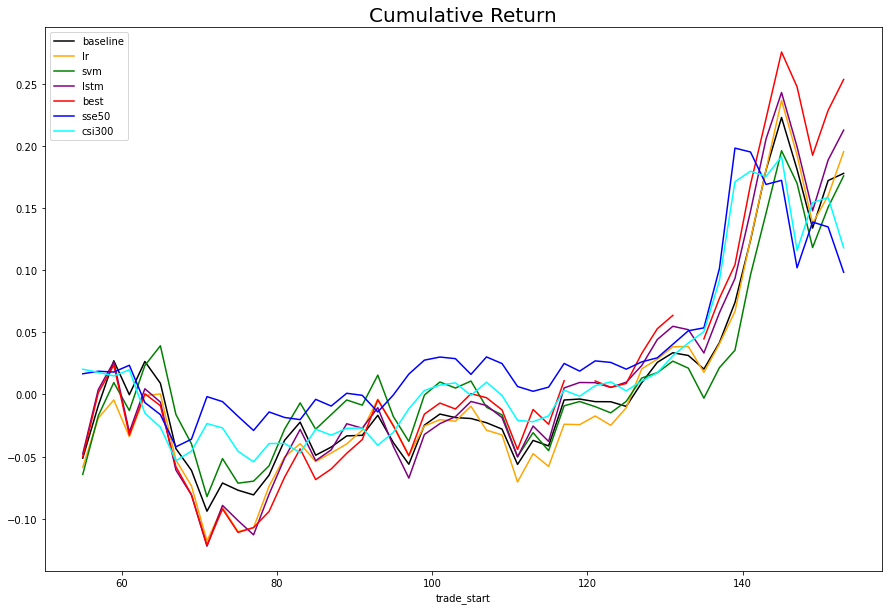

In [132]:
sse50_return = process_index("/content/drive/MyDrive/StockML /stock_data/china_index/sse50.csv", trade_starts)
csi300_return = process_index("/content/drive/MyDrive/StockML /stock_data/china_index/csi300.csv", trade_starts)
szi_return = process_index("/content/drive/MyDrive/StockML /stock_data/china_index/szi.csv", trade_starts)

plt.figure(figsize=(15,10))

baseline = ((df_equally_portfolio_return+1).cumprod()-1).plot(c='black',label='baseline')
lr = ((df_portfolio_return_lr+1).cumprod()-1).plot(c='orange',label='lr')
svm = ((df_portfolio_return_svm+1).cumprod()-1).plot(c='green',label='svm')
#ada = ((df_portfolio_return_ada+1).cumprod()-1).plot(c='plum',label='ada')
lstm = ((df_portfolio_return_lstm+1).cumprod()-1).plot(c='purple',label='lstm')
best = ((df_portfolio_return_best+1).cumprod()-1).plot(c='r',label='best')
sse50 = ((sse50_return+1).cumprod()-1).plot(c='b',label='sse50')
csi300 = ((csi300_return+1).cumprod()-1).plot(c='cyan',label='csi300')
#szi = ((szi_return+1).cumprod()-1).plot(c='gold',label='szi')
plt.legend()


plt.title('Cumulative Return',size=20)